In [82]:
import numpy as np
import pandas as pd

In [83]:
books = pd.read_csv('data/Books.csv')
users = pd.read_csv('data/Users.csv')
ratings = pd.read_csv('data/Ratings.csv')

C:\Users\asus\AppData\Local\Temp\ipykernel_9912\927319382.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('data/Books.csv')


In [84]:
books.isnull().sum()


ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [85]:
users.isnull().sum()


User-ID          0
Location         0
Age         110762
dtype: int64

In [86]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [87]:
books.duplicated().sum()

0

In [88]:
ratings.duplicated().sum()

0

EDA

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

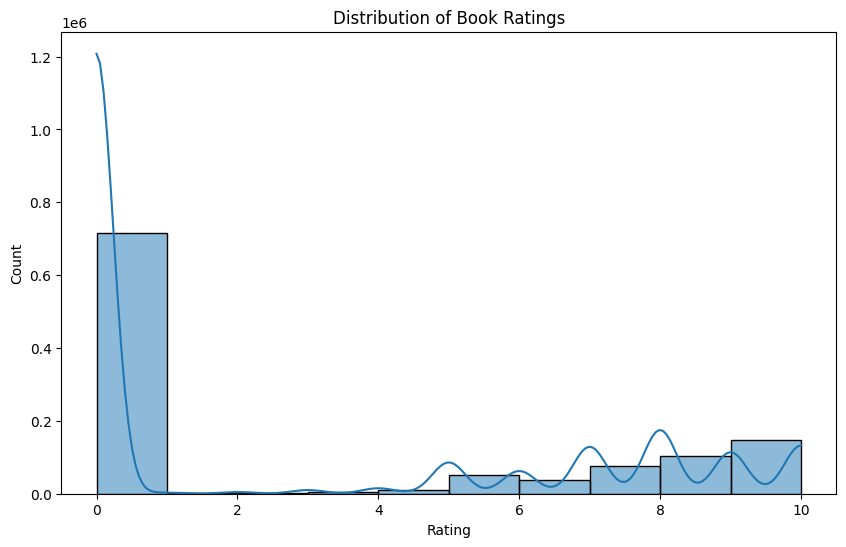

In [90]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings['Book-Rating'], bins=10, kde=True)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

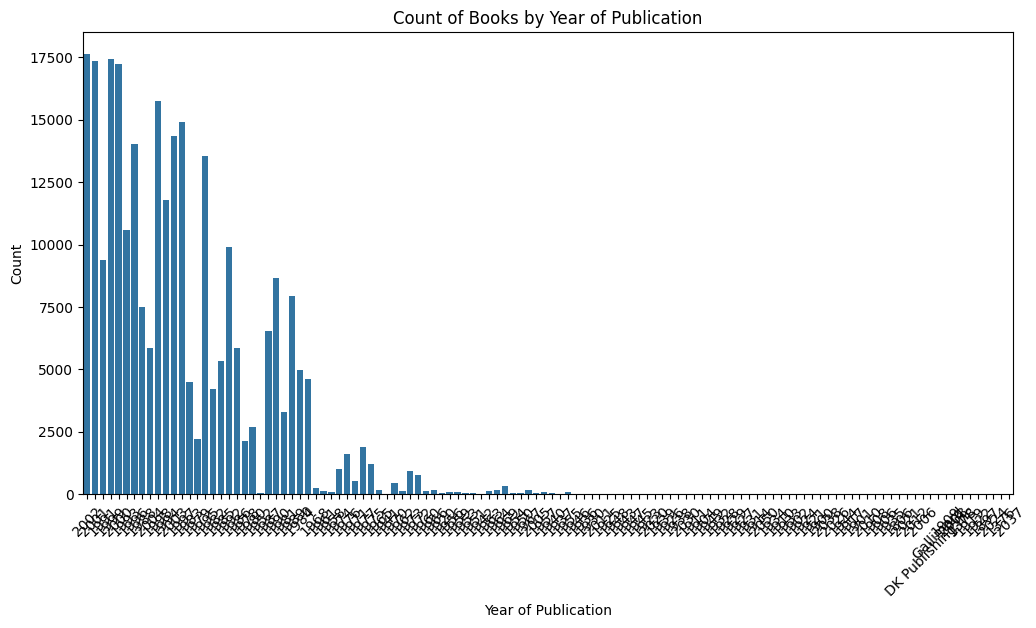

In [91]:
# Count plot of books by Year-Of-Publication
plt.figure(figsize=(12, 6))
sns.countplot(x='Year-Of-Publication', data=books)
plt.title('Count of Books by Year of Publication')
plt.xlabel('Year of Publication')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

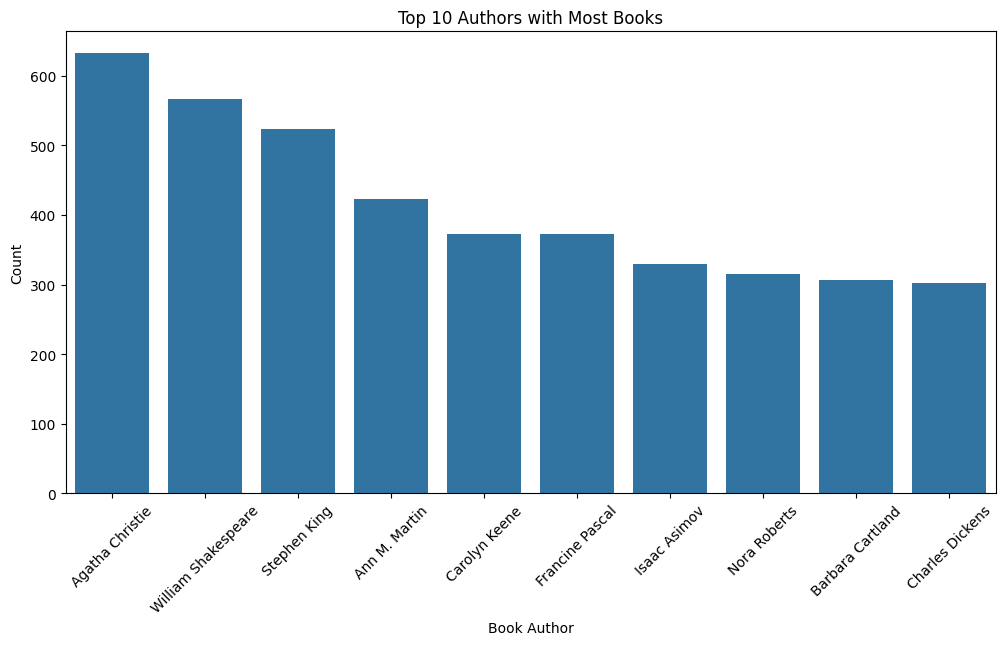

In [92]:
# Distribution of books by Author
plt.figure(figsize=(12, 6))
sns.countplot(x='Book-Author', data=books, order=books['Book-Author'].value_counts().index[:10])
plt.title('Top 10 Authors with Most Books')
plt.xlabel('Book Author')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

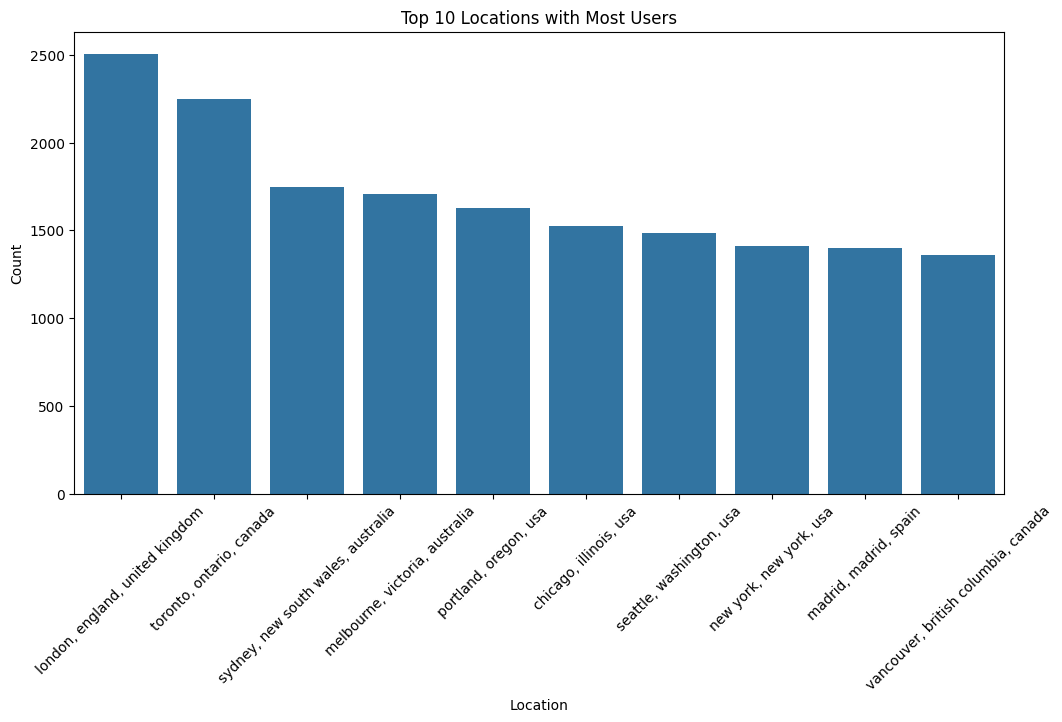

In [93]:
# Distribution of users by Location
plt.figure(figsize=(12, 6))
sns.countplot(x='Location', data=users, order=users['Location'].value_counts().index[:10])
plt.title('Top 10 Locations with Most Users')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Popularity Based Recommender System

In [94]:
#we consider those books with over 200 votes and display top 50 books with highest avg rating 

In [110]:
ratings_with_name = ratings.merge(books, on ='ISBN')

In [111]:
num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating' : 'Num_Ratings'}, inplace = True)


In [112]:
avg_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].mean().reset_index()

# Round the 'Book-Rating' column to 1 decimal place
avg_rating_df['Avg_Ratings'] = avg_rating_df['Book-Rating'].round(1)

# Drop the original 'Book-Rating' column if not needed
avg_rating_df.drop(columns=['Book-Rating'], inplace=True)

avg_rating_df.rename(columns={'Book-Rating' : 'Avg_Ratings'}, inplace = True)

avg_rating_df 


,Book-Title,Avg_Ratings
0,A Light in the Storm: The Civil War Diary of ...,2.2
1,Always Have Popsicles,0.0
2,Apple Magic (The Collector's series),0.0
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.0
4,Beyond IBM: Leadership Marketing and Finance ...,0.0
...,...,...
241066,Ã?Â?lpiraten.,0.0
241067,Ã?Â?rger mit Produkt X. Roman.,5.2
241068,Ã?Â?sterlich leben.,7.0
241069,Ã?Â?stlich der Berge.,2.7


In [119]:
popular_df = num_rating_df.merge(avg_rating_df , on='Book-Title')

In [120]:
popular_df= popular_df[popular_df['Num_Ratings'] >= 150].sort_values('Avg_Ratings' , ascending= False).head(50)
popular_df.shape


(50, 3)

In [121]:
popular_df = popular_df.merge(books , on='Book-Title').drop_duplicates('Book-Title')[['ISBN' ,'Book-Title' , 'Book-Author'  , 'Num_Ratings' , 'Avg_Ratings' , 'Year-Of-Publication' ,  'Image-URL-M']]
popular_df.shape


(50, 7)

In [ ]:
popular_df

Collaborative Filtering Based Rec System 

In [129]:
# filtering users by only taking experienced user's vote who have votes over 200 books
x = ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
useful_users = x[x].index

In [132]:
filtered_rating = ratings_with_name[ratings_with_name['User-ID'].isin(useful_users)]

In [136]:
#filtering books by taking books that have over 50 ratings 

In [138]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating'] >= 50
famous_books = y[y].index

In [141]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [143]:
#final_ratings.drop_duplicates()

In [145]:
pivot = final_ratings.pivot_table(index='Book-Title' , columns='User-ID' , values = 'Book-Rating')

In [147]:
pivot.fillna(0,inplace=True)

In [150]:
from sklearn.metrics.pairwise import cosine_similarity

In [152]:
similarity_scores = cosine_similarity(pivot)

In [205]:
similarity_scores.shape


(706, 706)

In [218]:
def recommend(book_name):
    #fetch index first
    # find the index of the respective book
    index = np.where(pivot.index == book_name)[0][0]

    # this means that first book ka dusri book ke respect me similarity score ye hai
    similar_items = sorted(list(enumerate(similarity_scores[index])), key = lambda x:x[1], reverse = True)[1:10]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = books[books['Book-Title'] == pivot.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))

        data.append(item)

    return data

In [1]:
recommend('The Da Vinci Code')

NameError: name 'recommend' is not defined

In [201]:
import pickle
pickle.dump(popular_df , open('popular.plk' , 'wb'))

In [222]:
pickle.dump(pivot, open('pivot.pkl' ,'wb'))
pickle.dump(books, open('books.pkl' ,'wb'))
pickle.dump(similarity_scores, open('similarity_scores.pkl' ,'wb'))